# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


## Libraries and datasets

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import itertools
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from t3_constants import *
from t3_utility import *

In [21]:
with open(f'{PICKLE_FOLDER}{LABELLED}{USER_DF}.pkl', 'rb') as f:
    u_df = pickle.load(f)

with open(f'{PICKLE_FOLDER}{PURE}{LABELLED}{USER_DF}.pkl', 'rb') as f:
    pure_u_df = pickle.load(f)

In [22]:
p_df = u_df[[ICNT, AIXB, PSUM]]
p_a, p_df = scale_df(p_df, 1)
p_df['all'] = p_df[ICNT] + p_df[AIXB] + p_df[PSUM]
p_df[LAB] = rankings(p_df['all'], 1, 8)
p_df[LAB] = p_df[LAB].map({0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2})
p_df.groupby(LAB).describe()

item_count                                                              \
           count      mean       std       min       25%       50%       75%   
label                                                                          
0          298.0 -0.888201  0.397820 -2.411239 -1.112819 -0.814663 -0.631922   
1          298.0  0.030876  0.373559 -0.958932 -0.252014  0.036524  0.286590   
2          199.0  1.283834  0.850363 -0.151026  0.805958  1.104114  1.520089   

                avg_items_per_basket            ... total_price            \
            max                count      mean  ...         75%       max   
label                                           ...                         
0      0.050951                298.0 -0.772918  ...   -0.559073 -0.002558   
1      1.118541                298.0 -0.001519  ...    0.269947  1.300844   
2      7.216308                199.0  1.159709  ...    1.470140  5.975984   

         all                                                              \
       count      mean       std       min       25%       50%       75%   
label                                                                      
0      298.0 -2.490040  0.985687 -6.125937 -3.132335 -2.353469 -1.651840   
1      298.0  0.018776  0.774217 -1.199055 -0.644531  0.057484  0.669673   
2      199.0  3.700687  2.470739  1.566486  2.202323  3.074980  4.252655   

                  
             max  
label             
0      -1.217540  
1       1.565934  
2      20.567831  

[3 rows x 32 columns]

<AxesSubplot:ylabel='Frequency'>

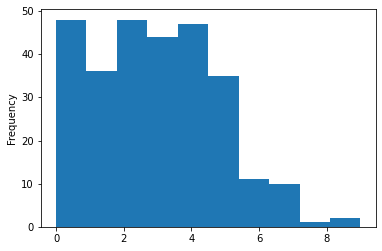

In [30]:
u_df['all'] = p_df[LAB]
u_df[u_df['all'] == 0][LAB].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

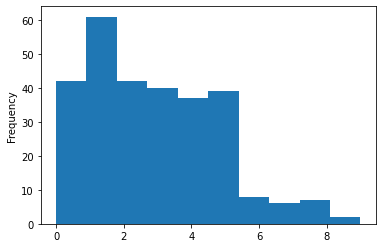

In [31]:
u_df[u_df['all'] == 1][LAB].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

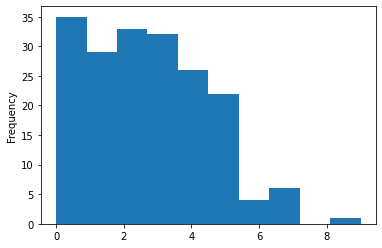

In [32]:
u_df[u_df['all'] == 2][LAB].plot(kind='hist')

In [61]:
u_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795 entries, 1 to 823
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   item_count            795 non-null    int64  
 1   item_dist_count       795 non-null    int64  
 2   max_items_per_b       795 non-null    int64  
 3   price_entropy         795 non-null    float64
 4   max_item_dist_per_b   795 non-null    int64  
 5   total_price           795 non-null    float64
 6   basket_count          795 non-null    int64  
 7   category_count        795 non-null    int64  
 8   shop_count            795 non-null    int64  
 9   avg_items_per_basket  795 non-null    float64
 10  avg_baskets_per_d     795 non-null    float64
 11  label                 754 non-null    object 
dtypes: float64(4), int64(7), object(1)
memory usage: 80.7+ KB


In [62]:
train_x, test_x, train_y, test_y = train_test_split(
    u_df[u_df[LAB].notna()].drop(columns=[LAB]),
    u_df[u_df[LAB].notna()][LAB],
    test_size=0.2,
    stratify=u_df[u_df[LAB].notna()][LAB])
x = train_x.values
y = train_y.values.ravel().astype(int)
y

array([1, 5, 0, 0, 3, 2, 5, 4, 2, 6, 3, 0, 0, 0, 1, 9, 2, 0, 1, 2, 3, 5,
       4, 1, 4, 2, 2, 6, 0, 4, 4, 5, 2, 2, 0, 0, 4, 4, 2, 4, 6, 0, 2, 4,
       4, 0, 4, 7, 3, 1, 1, 1, 3, 1, 4, 5, 8, 2, 0, 4, 1, 7, 4, 1, 5, 1,
       2, 3, 1, 0, 5, 1, 0, 3, 3, 2, 2, 0, 1, 3, 4, 7, 1, 1, 4, 1, 7, 2,
       5, 4, 3, 2, 3, 4, 4, 1, 9, 3, 1, 4, 2, 3, 5, 0, 4, 3, 0, 3, 5, 1,
       2, 1, 0, 4, 5, 2, 0, 1, 5, 0, 1, 4, 5, 2, 0, 3, 5, 4, 2, 4, 0, 0,
       2, 0, 9, 0, 2, 0, 3, 5, 5, 2, 0, 0, 2, 3, 5, 4, 0, 0, 5, 5, 6, 2,
       1, 2, 3, 6, 5, 0, 6, 4, 1, 2, 3, 7, 1, 0, 5, 3, 5, 3, 3, 0, 1, 3,
       1, 4, 5, 5, 0, 2, 0, 2, 2, 4, 1, 3, 0, 2, 3, 4, 1, 1, 5, 4, 2, 2,
       5, 0, 1, 3, 2, 4, 1, 3, 1, 3, 8, 3, 4, 1, 0, 4, 5, 5, 3, 1, 0, 3,
       1, 5, 0, 1, 4, 1, 5, 7, 4, 2, 5, 4, 1, 0, 3, 2, 5, 2, 0, 5, 0, 4,
       2, 2, 0, 2, 3, 3, 0, 6, 3, 1, 3, 2, 0, 3, 1, 1, 0, 3, 3, 5, 7, 2,
       4, 4, 1, 2, 2, 3, 4, 1, 0, 3, 4, 6, 1, 4, 3, 0, 2, 0, 3, 2, 1, 3,
       4, 5, 5, 5, 6, 0, 1, 3, 0, 3, 2, 2, 5, 2, 3,

In [63]:
def cross_validation(model, X: np.ndarray, y: np.ndarray, n_splits: int) -> np.ndarray:
    """Return validation scores across the k folds of cross-validation."""
    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    val_score = []
    for train_index, test_index in skf.split(X, y):
        model.fit(X[train_index], y[train_index].ravel())
        val_score.append(model.score(X[test_index], y[test_index].ravel() + 1))
    return np.array(val_score)

def cross_validation_summary(model, X: np.ndarray, y: np.ndarray, n_splits: int) -> np.ndarray:
    """Returns validation accuracy score of model (mean and std over all the splits)."""
    val_score = cross_validation(model, X, y, n_splits)
    return val_score.mean(), val_score.std()


In [65]:
## Hyper-parameters grid search for Decision Tree

hyp_dict = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0, 1, 1e-1, 1e-2, 1e-3, 1e-4],
    'min_samples_leaf': [1, 3, 5]
}
combinations = itertools.product(*(hyp_dict[key] for key in sorted(hyp_dict)))

results = []

for criterion, min_impurity_decrease, min_samples_leaf in combinations:
    model = tree.DecisionTreeClassifier(
        criterion=criterion,
        min_impurity_decrease=min_impurity_decrease,
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )
    mean_val_score, std_val_score = cross_validation_summary(model, x, y, 3)
    res = criterion, min_impurity_decrease, min_samples_leaf, mean_val_score, std_val_score
    results.append(res)

decision_tree_results_df = pd.DataFrame(results, columns=['criterion', 'min_impurity_decrease', 'min_samples_leaf', 'mean_val_score', 'std_val_score'])
decision_tree_results_df.sort_values('mean_val_score')

,criterion,min_impurity_decrease,min_samples_leaf,mean_val_score,std_val_score
35,entropy,0.0001,5,0.099502,0.007036
32,entropy,0.0010,5,0.099502,0.007036
20,entropy,0.0000,5,0.099502,0.007036
29,entropy,0.0100,5,0.101161,0.006205
26,entropy,0.1000,5,0.111111,0.078594
25,entropy,0.1000,3,0.111111,0.078594
24,entropy,0.1000,1,0.111111,0.078594
23,entropy,1.0000,5,0.111111,0.078594
22,entropy,1.0000,3,0.111111,0.078594
21,entropy,1.0000,1,0.111111,0.078594
